In [ ]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import sys
from glob import glob
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model

In [ ]:
#Install kaggle
! pip install -q kaggle

In [ ]:
#Upload the kaggle.json file you just downloaded
from google.colab import files
files.upload()

In [ ]:
#Make directory named kaggle 
!mkdir ~/.kaggle

In [ ]:
# copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/

In [ ]:
#change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
# Download the dataset zip in this location 
DATA_DIR = '../data'
IMAGE_DIR = '../data/images'
!mkdir ../data
!mkdir ../data/mask-vs-unmasked
!mkdir ../data/images

In [ ]:
#downloading the dataset from Kaggle
!kaggle datasets download -d pranavsingaraju/facemask-detection-dataset-20000-images -p {DATA_DIR}

 97% 584M/604M [00:04<00:00, 215MB/s]
100% 604M/604M [00:04<00:00, 155MB/s]


In [ ]:
#  Unzipping
shutil.unpack_archive(os.path.join(DATA_DIR,'facemask-detection-dataset-20000-images.zip'),DATA_DIR)
os.remove(os.path.join(DATA_DIR,'facemask-detection-dataset-20000-images.zip'))
# changing the data directory to KAGGLE_DIR
KAGGLE_DIR = os.path.join(DATA_DIR, 'mask-vs-unmasked')
# shutil.unpack_archive(os.path.join(DATA_DIR,'train.zip'),IMAGE_DIR)
# os.remove(os.path.join(DATA_DIR,'train.zip'))
# shutil.unpack_archive(os.path.join(DATA_DIR,'test1.zip'),DATA_DIR)
# os.remove(os.path.join(DATA_DIR,'test1.zip'))
# os.remove(os.path.join(DATA_DIR,'sampleSubmission.csv'))

In [ ]:
# Create train, validation, and test directories
split_dirs = ['train', 'validation', 'test']
for split_dir in split_dirs:
    # create label subdirectories
    label_dirs = ['with_mask', 'without_mask']
    for label_dir in label_dirs:
        new_dir = os.path.join(KAGGLE_DIR, split_dir, label_dir)
        os.makedirs(new_dir, exist_ok=True)

In [ ]:
# with_mask_vs_without_mask
# ├── test
# │   ├── with_mask
# │   └── without_mask
# ├── train
# |   ├── with_mask
# |   └── without_mask
# └── validation
#     ├── with_mask
#     └── without_mask

In [ ]:
# copy dataset images into subdirectories based on probability distribution 'p'
PERCENT_OF_DATA = 0.1
np.random.seed(42)
for folder in os.listdir(DATA_DIR):
  for file in os.listdir(os.path.join(DATA_DIR,folder)):
    if not file.endswith('.png'):
        continue # skip over non-image files
    src = os.path.join(DATA_DIR, folder, file)
    if np.random.uniform() > PERCENT_OF_DATA:
        os.remove(src)
        continue
    dst_dir = np.random.choice(['train', 'validation', 'test'], p=[.5, .25, .25])
    if file.startswith('with-mask'):
        dst = os.path.join(KAGGLE_DIR, dst_dir, 'with_mask', file)
    elif file.startswith('seed'):
        dst = os.path.join(KAGGLE_DIR, dst_dir, 'without_mask', file)
    try:
        shutil.move(src, dst)
    except Exception as e:
        print(e)
#Remove these empty diretories
# shutil.rmtree(DATA_DIR)

In [ ]:
#Number of images in each subdir
for dir_name in split_dirs:
    for label_dir in label_dirs:
        print(dir_name ,label_dir, len(os.listdir(KAGGLE_DIR + '/' + dir_name + '/' + label_dir)))

train with_mask 489
train without_mask 509
validation with_mask 247
validation without_mask 270
test with_mask 272
test without_mask 255


In [ ]:
# Preprocessing the image into a 4D tensor
img_path = glob(KAGGLE_DIR+'/*/*/*.png')[0]

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


In [ ]:
!ls

kaggle.json  sample_data


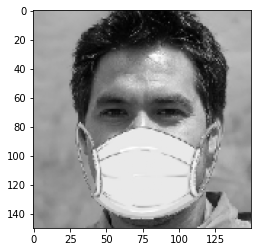

In [ ]:
# Displaying an example img
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
datagen = ImageDataGenerator(rescale=1/255)

NameError: ignored

In [ ]:
batch_size = 16
target_size = (75, 75)

traingen = datagen.flow_from_directory(directory='/data/mask-vs-unmasked/train', target_size=target_size, batch_size=batch_size, class_mode='categorical')
 
valgen = datagen.flow_from_directory(directory='/data/mask-vs-unmasked/validation', target_size=target_size, batch_size=batch_size, class_mode='categorical')

testgen = datagen.flow_from_directory(directory='/data/mask-vs-unmasked/test', target_size=target_size, batch_size=batch_size, class_mode='categorical')

Found 998 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 527 images belonging to 2 classes.


In [ ]:
print("Class Indices:", traingen.class_indices)

Class Indices: {'with_mask': 0, 'without_mask': 1}


In [ ]:
#Creating a CNN
CNN = Sequential()

CNN.add(Input(shape=(75, 75, 3)))

#Specify a list of the number of filters for each convolutional layer

for n_filters in [16, 32, 64]:
    CNN.add(Conv2D(n_filters,strides=(2, 2), kernel_size=3, activation='relu'))

# Fill in the layer needed between our 2d convolutional layers and the dense layer
CNN.add(Flatten())

#Specify the number of nodes in the dense layer before the output
CNN.add(Dense(128, activation='relu'))

#Specify the output layer
CNN.add(Dense(2, activation='softmax'))
 
#Compiling the model
CNN.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

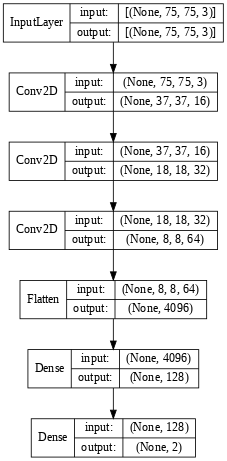

In [ ]:
plot_model(CNN, show_shapes=True, show_layer_names=False, dpi=60)

In [ ]:
# Training the CNN model
history = CNN.fit(traingen,
        epochs=20,
        validation_data=valgen)

Epoch 1/20
63/63 [==============================] - 4s 52ms/step - loss: 0.2257 - accuracy: 0.8998 - val_loss: 0.0272 - val_accuracy: 0.9942
Epoch 2/20
63/63 [==============================] - 3s 44ms/step - loss: 0.0131 - accuracy: 0.9960 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 3/20
63/63 [==============================] - 3s 42ms/step - loss: 0.0114 - accuracy: 0.9980 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 4/20
63/63 [==============================] - 3s 42ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9981
Epoch 5/20
63/63 [==============================] - 3s 44ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.1749e-04 - val_accuracy: 1.0000
Epoch 6/20
63/63 [==============================] - 3s 41ms/step - loss: 2.1171e-04 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 0.9981
Epoch 7/20
63/63 [==============================] - 3s 41ms/step - loss: 1.5830e-04 - accuracy: 1.0000 - val_loss: 2.8640e-04 - val_accuracy: 1.00

In [ ]:
CNN.evaluate(testgen)

33/33 [==============================] - 1s 29ms/step - loss: 1.5215e-05 - accuracy: 1.0000


[1.5215243365673814e-05, 1.0]

Text(0.5, 1.0, 'Accuracy Plot')

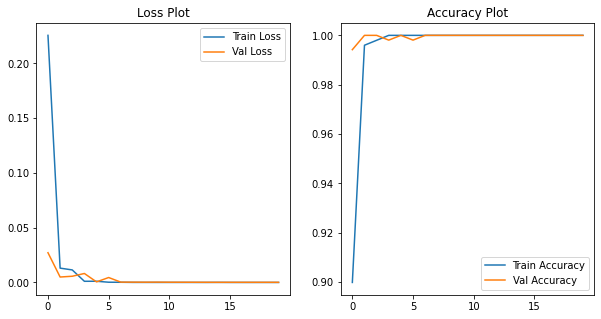

In [ ]:
# Plotting the loss and accuracy plots
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(history.history['loss'], label="Train Loss")
ax[0].plot(history.history['val_loss'], label="Val Loss")
ax[1].plot(history.history['accuracy'], label="Train Accuracy")
ax[1].plot(history.history['val_accuracy'], label="Val Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Loss Plot")
ax[1].set_title("Accuracy Plot")

In [ ]:
# Augmenting the data using ImageDataGenerator
datagen_aug = ImageDataGenerator(rotation_range=180,
                                 width_shift_range=.1, height_shift_range=.1,
                                 rescale=1/255,
                                 zoom_range=.2,
                                 horizontal_flip=True)
traingen_aug = datagen_aug.flow_from_directory("/data/mask-vs-unmasked/train", target_size=target_size,
                                               class_mode='categorical', batch_size=32)

Found 998 images belonging to 2 classes.


In [ ]:
os.listdir('../data/mask-vs-unmasked/train/without_mask/')

['seed0515.png',
 'seed7622.png',
 'seed9398.png',
 'seed1165.png',
 'seed9499.png',
 'seed6071.png',
 'seed5632.png',
 'seed2916.png',
 'seed3294.png',
 'seed8568.png',
 'seed3437.png',
 'seed5447.png',
 'seed8772.png',
 'seed3641.png',
 'seed6399.png',
 'seed9588.png',
 'seed9516.png',
 'seed2017.png',
 'seed8934.png',
 'seed5420.png',
 'seed2155.png',
 'seed9976.png',
 'seed3158.png',
 'seed6834.png',
 'seed9731.png',
 'seed0766.png',
 'seed4578.png',
 'seed9530.png',
 'seed6692.png',
 'seed3367.png',
 'seed8112.png',
 'seed0867.png',
 'seed0552.png',
 'seed5350.png',
 'seed4927.png',
 'seed9786.png',
 'seed5097.png',
 'seed5477.png',
 'seed2733.png',
 'seed0111.png',
 'seed1608.png',
 'seed7354.png',
 'seed1843.png',
 'seed1373.png',
 'seed7347.png',
 'seed2673.png',
 'seed6192.png',
 'seed1526.png',
 'seed8308.png',
 'seed7168.png',
 'seed5946.png',
 'seed7806.png',
 'seed2588.png',
 'seed2723.png',
 'seed2930.png',
 'seed8740.png',
 'seed3505.png',
 'seed0138.png',
 'seed5157.png

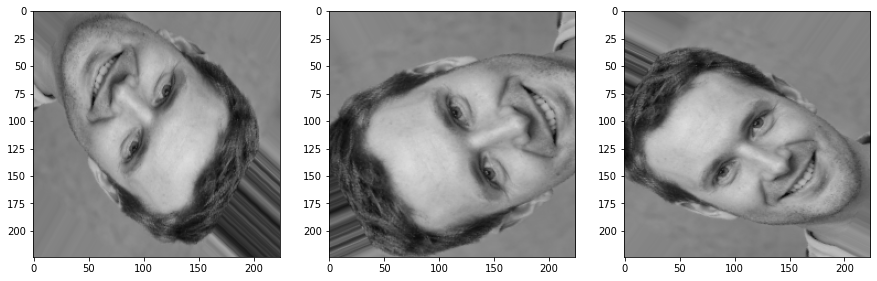

In [ ]:
# Looking at the data
img = image.load_img('/data/mask-vs-unmasked/train/without_mask/seed4547.png')
img = image.img_to_array(img)
img = np.array([img])
aug_iter = datagen_aug.flow(img, batch_size=1)
fig, ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
  img_aug= next(aug_iter)[0]
  ax[i].imshow(img_aug)

In [ ]:
#Creating a CNN
CNN_aug = Sequential()

CNN_aug.add(Input(shape=(75, 75, 3)))

#Specify a list of the number of filters for each convolutional layer

for n_filters in [16,32, 64]:
    CNN_aug.add(Conv2D(n_filters,strides=(2, 2), kernel_size=3, activation='relu'))

# Fill in the layer needed between our 2d convolutional layers and the dense layer
CNN_aug.add(Flatten())

#Specify the number of nodes in the dense layer before the output
CNN_aug.add(Dense(128, activation='relu'))

#Specify the output layer
CNN_aug.add(Dense(2, activation='softmax'))
 
#Compiling the model
CNN_aug.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

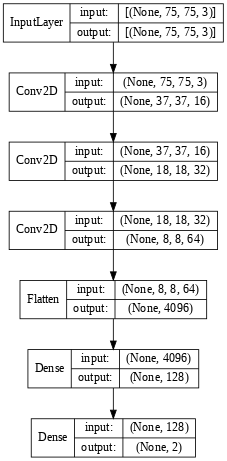

In [ ]:
plot_model(CNN_aug, show_shapes=True, show_layer_names=False, dpi=60)

In [ ]:
# Training the model
history_aug = CNN_aug.fit(traingen_aug,
        epochs=20,
        validation_data=valgen)

Epoch 1/20
32/32 [==============================] - 4s 115ms/step - loss: 0.6871 - accuracy: 0.5381 - val_loss: 0.6709 - val_accuracy: 0.4816
Epoch 2/20
32/32 [==============================] - 3s 105ms/step - loss: 0.6251 - accuracy: 0.6463 - val_loss: 0.5134 - val_accuracy: 0.7176
Epoch 3/20
32/32 [==============================] - 3s 102ms/step - loss: 0.4763 - accuracy: 0.7856 - val_loss: 0.3520 - val_accuracy: 0.8607
Epoch 4/20
32/32 [==============================] - 4s 109ms/step - loss: 0.2899 - accuracy: 0.8988 - val_loss: 0.1520 - val_accuracy: 0.9884
Epoch 5/20
32/32 [==============================] - 3s 107ms/step - loss: 0.2297 - accuracy: 0.9269 - val_loss: 0.1109 - val_accuracy: 0.9845
Epoch 6/20
32/32 [==============================] - 5s 143ms/step - loss: 0.1500 - accuracy: 0.9509 - val_loss: 0.0692 - val_accuracy: 0.9845
Epoch 7/20
32/32 [==============================] - 3s 107ms/step - loss: 0.1193 - accuracy: 0.9619 - val_loss: 0.0547 - val_accuracy: 0.9826
Epoch 

Text(0.5, 1.0, 'Accuracy Plot')

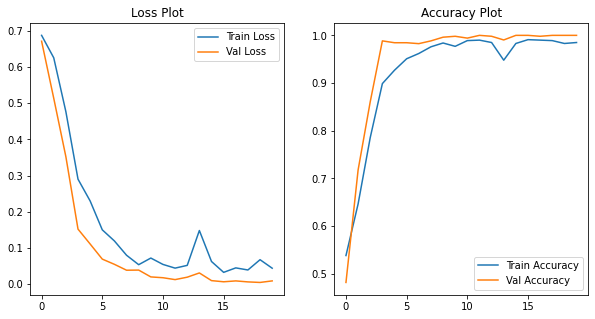

In [ ]:
# Plotting the loss and accuracy plots
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(history_aug.history['loss'], label="Train Loss")
ax[0].plot(history_aug.history['val_loss'], label="Val Loss")
ax[1].plot(history_aug.history['accuracy'], label="Train Accuracy")
ax[1].plot(history_aug.history['val_accuracy'], label="Val Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Loss Plot")
ax[1].set_title("Accuracy Plot")

In [ ]:
CNN_aug.evaluate(testgen, steps=650/batch_size)

31/40 [=====================>........] - ETA: 0s - loss: 0.0119 - accuracy: 0.9980

40/40 [==============================] - 1s 18ms/step - loss: 0.0114 - accuracy: 0.9981


[0.011386928148567677, 0.9981024861335754]

In [ ]:
CNN_aug.save_weights('model_weights.h5')

In [ ]:
CNN_aug_new = Sequential()

CNN_aug_new.add(Input(shape=(75, 75, 3)))

#Specify a list of the number of filters for each convolutional layer

for n_filters in [16,32, 64]:
    CNN_aug_new.add(Conv2D(n_filters,strides=(2, 2), kernel_size=3, activation='relu'))

# Fill in the layer needed between our 2d convolutional layers and the dense layer
CNN_aug_new.add(Flatten())

#Specify the number of nodes in the dense layer before the output
CNN_aug_new.add(Dense(128, activation='relu'))

#Specify the output layer
CNN_aug_new.add(Dense(2, activation='softmax'))
 
#Compiling the model
CNN_aug_new.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
CNN_aug_new.load_weights('model_weights.h5')

In [ ]:
img = image.load_img('/data/mask-vs-unmasked/validation/without_mask/seed3128.png',target_size=(75, 75))
img = image.img_to_array(img)
img = np.array([img])
aug_iter = datagen.flow(img, batch_size=1)
prediction=CNN_aug_new.predict(aug_iter)
prediction

1/1 [==============================] - 0s 33ms/step


array([[6.9088966e-04, 9.9930906e-01]], dtype=float32)

Text(0.5, 1.0, 'wihout_mask')

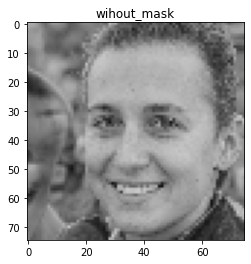

In [ ]:
img = image.load_img('//data/mask-vs-unmasked/validation/without_mask/seed3128.png',target_size=(75, 75))
plt.imshow(img)
plt.title('with_mask' if np.argmax(prediction)==0 else "wihout_mask")